# Generative Adversarial Networks in Slanted Land

In this notebook, we build a very simple pair of GANs.
- The dataset is a dataset of 2x2 black and white images, where the images we want to generate (the faces) are backwards diagonals (\\)
- The neural networks only have one layer.

### Imports

In [1]:
# Imports
import numpy as np
from numpy import random
from matplotlib import pyplot as plt
%matplotlib inline

### Plotting function

In [4]:
# Drawing function

def view_samples(samples, m, n):
    fig, axes = plt.subplots(figsize=(10, 10), nrows=m, ncols=n, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((2,2)), cmap='Greys_r')  
    return fig, axes

# Examples of faces

In the video, we've defined the faces as backwards diagonals. Here are some examples.

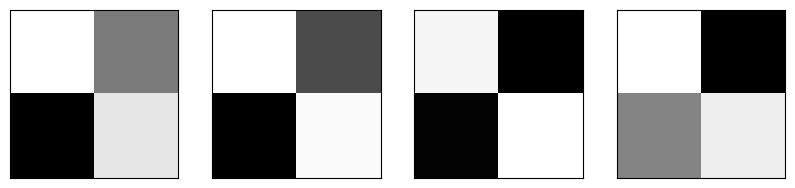

In [5]:
# Examples of faces

# Creating dataset of 100 faces
firsts = np.random.uniform(0.6, 1, (1,100))
seconds_thirds = np.random.uniform(0, 0.4, (2,100))
fourth = np.random.uniform(0.6, 1, (1,100))
faces = np.concatenate((firsts, seconds_thirds, fourth), axis=0).T

random_faces = faces[np.random.choice(faces.shape[0], size=4)]
_ = view_samples(random_faces, 1, 4)

# Examples of noise
The following are randomly generated images, which don't correspond to faces.

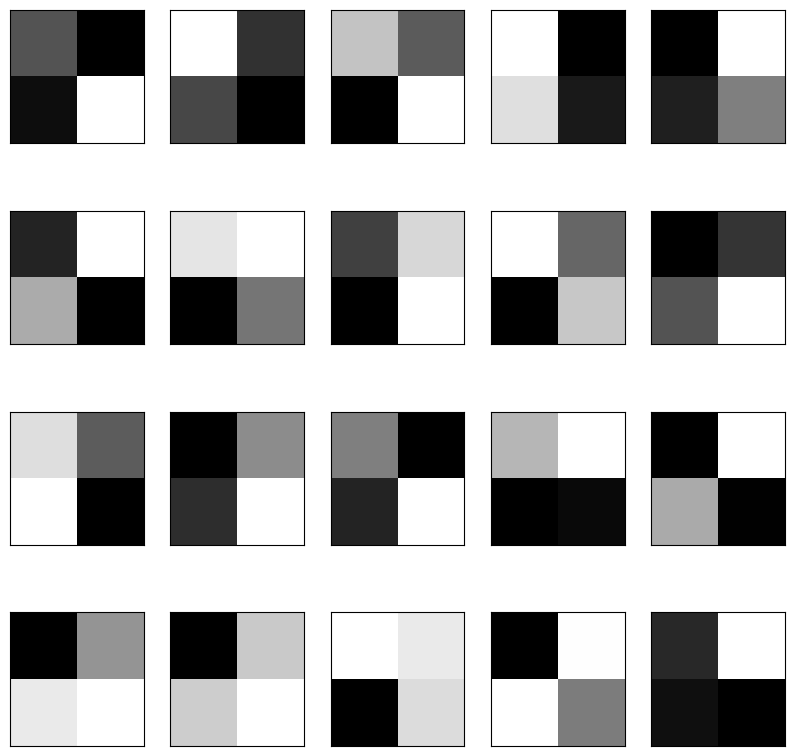

In [6]:
# Examples of noisy images
noise = [np.random.randn(2,2) for i in range(20)]
# def generate_random_image():
    # return [np.random.random(), np.random.random(), np.random.random(), np.random.random()]

_ = view_samples(noise, 4,5)

# Building the neural networks

In [7]:
# The sigmoid activation function
def sigmoid(x):
    return np.exp(x)/(1.0+np.exp(x))

## The Discriminator

<img src="discriminator_math.png" />

In [58]:
class Discriminator():
    def __init__(self):
        #self.weights = np.array([0.0 for i in range(4)])
        #self.bias = 0.0
        self.weights = np.array([np.random.normal() for i in range(4)])
        self.bias = np.random.normal()
    
    def forward(self, x):
        # Forward pass
        return sigmoid(np.dot(x, self.weights) + self.bias)
    
    def error_from_image(self, image):
        prediction = self.forward(image)
        # We want the prediction to be 1, so the error is -log(prediction)
        return -np.log(prediction)
    
    def derivatives_from_image(self, image):
        prediction = self.forward(image)
        derivatives_weights = -image * (1-prediction)
        derivative_bias = -(1-prediction)
        return derivatives_weights, derivative_bias
    
    def update_from_image(self, x):
        ders = self.derivatives_from_image(x)
        self.weights -= learning_rate * ders[0]
        self.bias -= learning_rate * ders[1]

    def error_from_noise(self, noise):
        prediction = self.forward(noise)
        # We want the prediction to be 0, so the error is -log(1-prediction)
        return -np.log(1-prediction)
    
    def derivatives_from_noise(self, noise):
        prediction = self.forward(noise)
        derivatives_weights = noise * prediction
        derivative_bias = prediction
        return derivatives_weights, derivative_bias
    
    def update_from_noise(self, noise):
        ders = self.derivatives_from_noise(noise)
        self.weights -= learning_rate * ders[0]
        self.bias -= learning_rate * ders[1]

## The Generator
<img src="generator_math.png" />

In [59]:
class Generator():
    def __init__(self):
        self.weights = np.array([np.random.normal() for i in range(4)])
        self.biases = np.array([np.random.normal() for i in range(4)])

    def forward(self, z):
        # Forward pass
        return sigmoid(z * self.weights + self.biases)

    def error(self, z, discriminator):
        x = self.forward(z)
        # We want the prediction to be 0, so the error is -log(1-prediction)  , wait isnt this comment wrong? we want the prediction to be 1.
        y = discriminator.forward(x)
        return -np.log(y)

    def derivatives(self, z, discriminator):
        discriminator_weights = discriminator.weights
        discriminator_bias = discriminator.bias
        x = self.forward(z)
        y = discriminator.forward(x)
        factor = -(1-y) * discriminator_weights * x *(1-x)  
        derivatives_weights = factor * z
        derivative_bias = factor
        return derivatives_weights, derivative_bias

    def update(self, z, discriminator):
        error_before = self.error(z, discriminator)
        ders = self.derivatives(z, discriminator)
        self.weights -= learning_rate * ders[0]
        self.biases -= learning_rate * ders[1]
        error_after = self.error(z, discriminator)   # why calculate error_after?

# Training

In [91]:
# Set random seed
np.random.seed(42)

# Hyperparameters
learning_rate = 0.01
epochs = 1000

# The GAN
D = Discriminator()
G = Generator()

# For the error plot
errors_discriminator = []
errors_generator = []

for epoch in range(epochs):
    
    for face in faces[:4]:   # looping over each sample. can be vectorized. and why use such a small dataset?
        
        # Update the discriminator weights from the real face
        D.update_from_image(face)
    
        # Pick a random number to generate a fake face
        z = random.rand()

        # Calculate the discriminator error
        errors_discriminator.append(sum(D.error_from_image(face) + D.error_from_noise(z)))
        
        # Calculate the generator error
        errors_generator.append(G.error(z, D))
        
        # Build a fake face
        noise = G.forward(z)
        
        # Update the discriminator weights from the fake face
        D.update_from_noise(noise)
    
        # Update the generator weights from the fake face
        G.update(z, D)

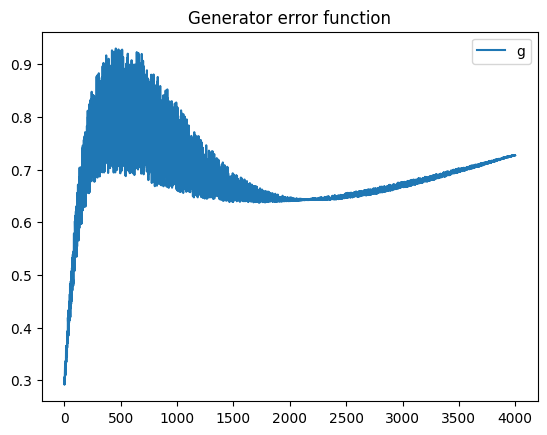

Text(0.5, 1.0, 'Discriminator error function')

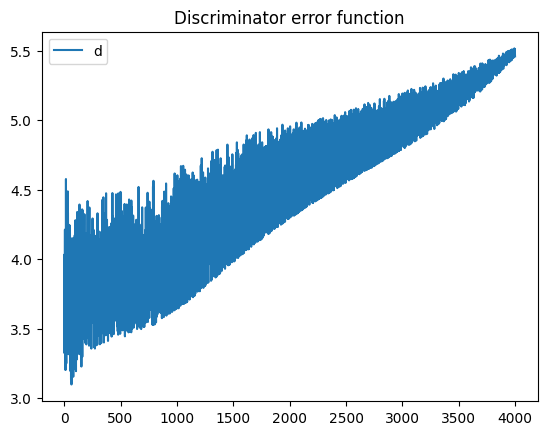

In [92]:
import matplotlib.pyplot as plt
plt.plot(errors_generator)
plt.title("Generator error function")
plt.legend("gen")
plt.show()
plt.plot(errors_discriminator)
plt.legend('disc')
plt.title("Discriminator error function")

# Generating images

[0.86781891 0.05182893 0.0840668  0.93296708]
[0.8648625  0.0510616  0.0850554  0.93026453]
[0.87270278 0.05315398 0.08241561 0.93732514]
[0.86532912 0.05118104 0.08489989 0.9306943 ]


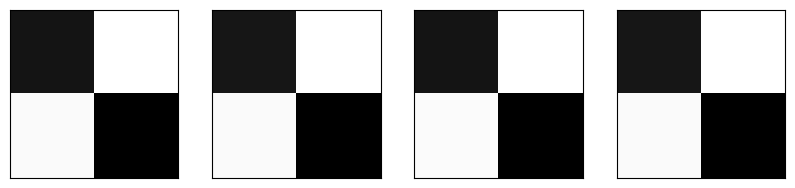

In [93]:
generated_images = []
for i in range(4):
    z = random.random()
    generated_image = G.forward(z)
    generated_images.append(generated_image)
    
_ = view_samples(generated_images, 1, 4)
for i in generated_images:
    print(i)

# Studying the weights and biases of the Generator and Discriminator

In [94]:
print("Generator weights", G.weights)
print("Generator biases", G.biases)

Generator weights [ 0.37941914  0.2336754  -0.18977953  0.63046557]
Generator biases [ 1.76901374 -2.9760551  -2.33191265  2.44575679]


In [95]:
print("Discriminator weights", D.weights)
print("Discriminator bias", D.bias)

Discriminator weights [ 0.08981193 -0.05869293 -0.01276742 -0.04095412]
Discriminator bias -0.11617427358852273


# Coding it by myself

In [24]:
class Discriminator():
    def __init__(self):
        self.W = np.random.normal(size=(1,4))
        self.bias = np.random.normal(size=(1,1))
        self.losses = []

    def forward(self, x):
        assert x.shape == (4,1)
        return sigmoid(self.W @ x + self.bias)
    
    def loss(self, x, y):
        J = - (y * np.log(x) + (1 - y) * np.log(1 - x))   # x = D(x), y = 1 for real images from train set
        return J.flatten()[0]                               # x = D(G(z)), y = 0 for images generated by generator

    def gradients(self, D_x, y, x):
        """
        D_x: D(x) discriminator output
        y: true label (1 for real, 0 for fake)
        x: input image (4,1)
        """
        dw = (D_x - y) * x.T
        db = D_x - y
        return dw, db
    
    def update(self, D_x, y, x, lr):
        dW, db = self.gradients(D_x, y, x)
        self.W -= lr * dW
        self.bias -= lr * db



class Generator():
    def __init__(self):
        self.W = np.random.normal(size=(4,1))
        self.bias = np.random.normal(size=(4,1))
        self.losses = []

    def forward(self, z):
        assert z.shape == (1,1)
        return sigmoid(self.W * z + self.bias)
    
    def loss(self, D_G_z):
        return - np.log(D_G_z).flatten()[0]   # we want D(G(z)) to be 1

    def gradients(self, D, D_G_z, G_z, z):
        """
        D: Discriminator object
        z: input noise (1,1)
        """
        #G_z = self.forward(z) # (4,1)
        #D_G_z = D.forward(G_z) # scalar
        factor = (D_G_z - 1) * D.W.T * G_z * (1 - G_z) # (4,1)
        dW = factor * z
        db = factor
        return dW, db
    
    def update(self, D, D_G_z, G_z, z, lr):
        dW, db = self.gradients(D, D_G_z, G_z, z)
        self.W -= lr * dW
        self.bias -= lr * db

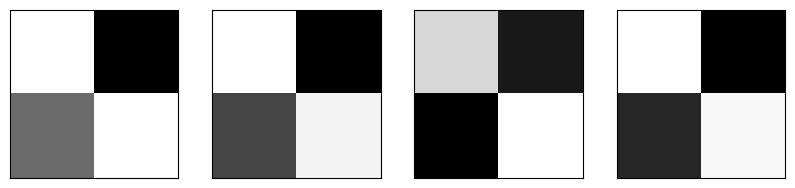

In [35]:
random_faces = faces[np.random.choice(faces.shape[0], size=8)]
_ = view_samples(random_faces, 1, 4)

In [36]:
random_faces

array([[0.94463225, 0.10627493, 0.39718811, 0.93892267],
       [0.87993192, 0.0201614 , 0.20511281, 0.792975  ],
       [0.68850123, 0.34746625, 0.30326438, 0.8249114 ],
       [0.7977681 , 0.28416099, 0.35147785, 0.77015219],
       [0.7977681 , 0.28416099, 0.35147785, 0.77015219],
       [0.62823819, 0.13215518, 0.09698174, 0.89172354],
       [0.7977681 , 0.28416099, 0.35147785, 0.77015219],
       [0.94246315, 0.04984675, 0.07335638, 0.64200102]])

In [78]:
np.random.seed(42)
lr = 0.01
epochs = 1000

D = Discriminator()
G = Generator()

for epoch in range(epochs):

    for face in random_faces:
        face = face.reshape((4,1))

        # Train Discriminator on real image
        D_x = D.forward(face)
        D_loss_real = D.loss(D_x, 1) # discriminator error on real image
        D.update(D_x, 1, face, lr)

        # Train Discriminator on fake image
        z = np.random.rand(1,1)
        G_z = G.forward(z)
        D_G_z = D.forward(G_z)

        G_loss = G.loss(D_G_z)         # Generator error
        D_loss_fake = D.loss(D_G_z, 0) # discriminator error on fake image

        D.update(D_G_z, 0, G_z, lr)

        # Train Generator
        G.update(D, D_G_z, G_z, z, lr)

        D.losses.append(D_loss_real + D_loss_fake)
        G.losses.append(G_loss)

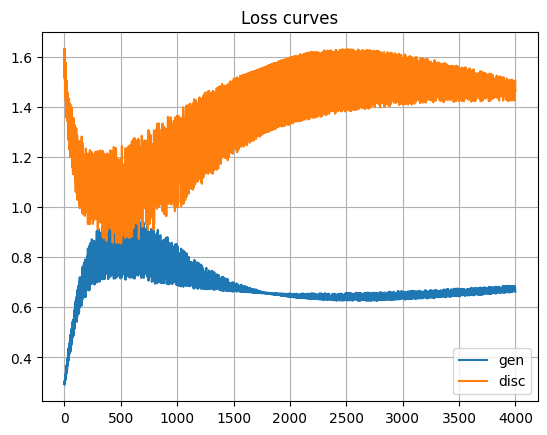

In [79]:
plt.plot(G.losses, label='gen')
plt.plot(D.losses, label='disc')
plt.title("Loss curves")
plt.grid(True)
plt.legend()
plt.show()

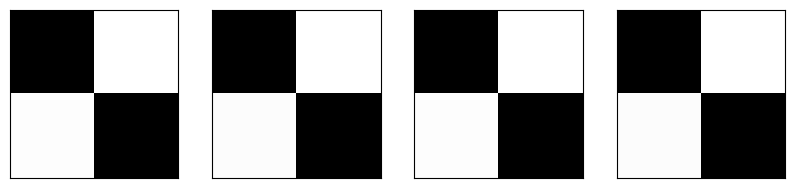

In [80]:
generated_images = []
for i in range(4):
    z = np.random.rand(1,1)
    generated_image = G.forward(z)
    generated_images.append(generated_image)
    
_ = view_samples(generated_images, 1, 4)

In [63]:
G.W, G.bias


(array([[ 0.72611721],
        [ 0.18345701],
        [-0.31410958],
        [ 0.67501177]]),
 array([[ 2.52264092],
        [-3.07689457],
        [-2.59478426],
        [ 2.54762909]]))

In [64]:
D.W, D.bias

(array([[ 1.11134654, -0.29007325, -0.45947122,  0.23298008]]),
 array([[-1.20261196]]))

In [74]:
D.forward(generated_images[2])

array([[0.48085626]])

# Improved Code

In [ ]:
class Discriminator():
    def __init__(self):
        self.W = np.random.normal(loc=0, scale=0.01, size=(1,4))  # Better initialization
        self.bias = np.random.normal(loc=0, scale=0.01, size=(1,1))
        self.losses = []

    def forward(self, x):
        assert x.shape == (4,1), f"Expected shape (4,1), got {x.shape}"
        return sigmoid(self.W @ x + self.bias)
    
    def loss(self, x, y):
        # Numerical stability: clamp to avoid log(0)
        x = np.clip(x, 1e-7, 1 - 1e-7)
        J = -(y * np.log(x) + (1 - y) * np.log(1 - x))  # x = D(x), y = 1 for real images from train set, x = D(G(z)), y = 0 for images generated by generator
        return float(J.flatten()[0])
    
    def gradients(self, D_x, y, x):
        dw = (D_x - y) * x.T
        db = D_x - y
        return dw, db
    
    def update(self, D_x, y, x, lr):
        dW, db = self.gradients(D_x, y, x)
        self.W -= lr * dW
        self.bias -= lr * db


class Generator():
    def __init__(self):
        self.W = np.random.normal(loc=0, scale=0.01, size=(4,1))
        self.bias = np.random.normal(loc=0, scale=0.01, size=(4,1))
        self.losses = []

    def forward(self, z):
        assert z.shape == (1,1), f"Expected shape (1,1), got {z.shape}"
        return sigmoid(self.W * z + self.bias)
    
    def loss(self, D_G_z):
        D_G_z = np.clip(D_G_z, 1e-7, 1 - 1e-7)
        return float(-np.log(D_G_z).flatten()[0])

    def gradients(self, D, D_G_z, G_z, z):
        factor = (D_G_z - 1) * D.W.T * G_z * (1 - G_z)
        dW = factor * z
        db = factor
        return dW, db
    
    def update(self, D, D_G_z, G_z, z, lr):
        dW, db = self.gradients(D, D_G_z, G_z, z)
        self.W -= lr * dW
        self.bias -= lr * db


class GANTrainer:
    """Encapsulate training logic for better separation of concerns"""
    def __init__(self, discriminator, generator, lr=0.01, epochs=1000):
        self.D = discriminator
        self.G = generator
        self.lr = lr
        self.epochs = epochs
        self.history = {'D_loss': [], 'G_loss': []}
    
    def train(self, real_data):
        for epoch in range(self.epochs):
            epoch_d_loss, epoch_g_loss = 0, 0
            
            for face in real_data:
                face = face.reshape((4,1))
                
                # Train Discriminator
                D_x = self.D.forward(face)
                D_loss_real = self.D.loss(D_x, 1)
                self.D.update(D_x, 1, face, self.lr)
                
                z = np.random.rand(1,1)
                G_z = self.G.forward(z)
                D_G_z = self.D.forward(G_z)
                D_loss_fake = self.D.loss(D_G_z, 0)
                self.D.update(D_G_z, 0, G_z, self.lr)
                
                # Train Generator
                G_loss = self.G.loss(D_G_z)
                self.G.update(self.D, D_G_z, G_z, z, self.lr)
                
                epoch_d_loss += (D_loss_real + D_loss_fake) / 2
                epoch_g_loss += G_loss
            
            self.history['D_loss'].append(epoch_d_loss / len(real_data))
            self.history['G_loss'].append(epoch_g_loss / len(real_data))
            
            if (epoch + 1) % 100 == 0 or epoch==0:
                print(f"Epoch {epoch+1}/{self.epochs} | "
                      f"D_loss: {self.history['D_loss'][-1]:.4f} | "
                      f"G_loss: {self.history['G_loss'][-1]:.4f}")
    
    def plot_history(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.history['G_loss'], label='Generator', alpha=0.7)
        plt.plot(self.history['D_loss'], label='Discriminator', alpha=0.7)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss Curves')
        plt.legend()
        plt.grid(True)
        plt.show()

Epoch 1/1000 | D_loss: 0.6937 | G_loss: 0.6832
Epoch 100/1000 | D_loss: 0.5524 | G_loss: 0.7969
Epoch 200/1000 | D_loss: 0.5654 | G_loss: 0.7659
Epoch 300/1000 | D_loss: 0.6268 | G_loss: 0.7214
Epoch 400/1000 | D_loss: 0.7098 | G_loss: 0.6342
Epoch 500/1000 | D_loss: 0.7357 | G_loss: 0.6345
Epoch 600/1000 | D_loss: 0.7449 | G_loss: 0.6448
Epoch 700/1000 | D_loss: 0.7477 | G_loss: 0.6527
Epoch 800/1000 | D_loss: 0.7271 | G_loss: 0.6897
Epoch 900/1000 | D_loss: 0.7317 | G_loss: 0.6731
Epoch 1000/1000 | D_loss: 0.7223 | G_loss: 0.6785


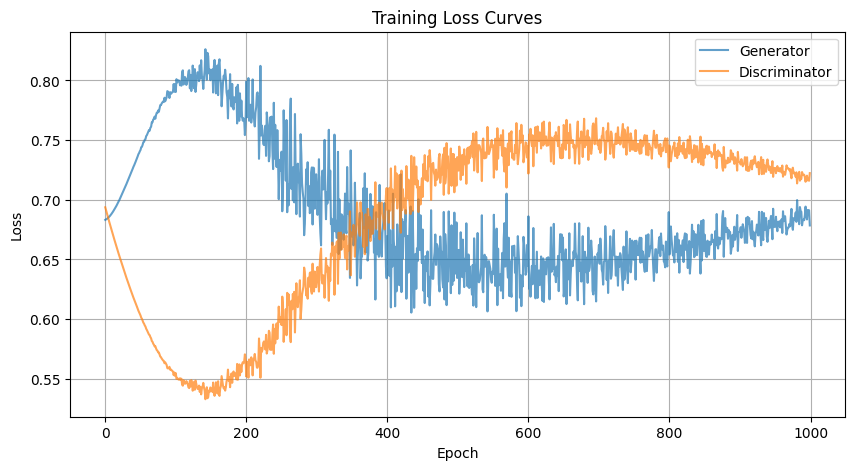

In [17]:
# Usage
np.random.seed(42)
D = Discriminator()
G = Generator()
trainer = GANTrainer(D, G, lr=0.01, epochs=1000)
trainer.train(random_faces)
trainer.plot_history()

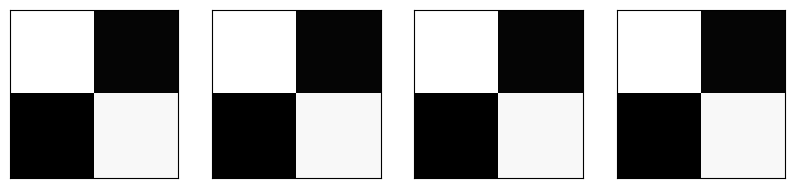

In [18]:
generated_images = []
for i in range(4):
    z = np.random.rand(1,1)
    generated_image = G.forward(z)
    generated_images.append(generated_image)
    
_ = view_samples(generated_images, 1, 4)

In [20]:
D.forward(generated_images[2])

array([[0.49975414]])

# Vectorized GAN

In [48]:
# Vectorized GAN Implementation

class VectorizedDiscriminator():
    """Discriminator that processes batches of images."""
    def __init__(self):
        """Initialize discriminator with random weights and bias."""
        self.W = np.random.normal(loc=0, scale=0.01, size=(1, 4))
        self.bias = np.random.normal(loc=0, scale=0.01, size=(1, 1))
        self.losses = []

    def forward(self, X):
        """
        Forward pass through discriminator.
        
        Args:
            X: Batch of images, shape (4, n_samples) columns are samples
            
        Returns:
            Discriminator outputs, shape (n_samples, 1)
        """
        assert X.shape[0] == 4, f"Expected shape (4, n), got {X.shape}"
        return sigmoid(self.W @ X + self.bias)
    
    def loss(self, predictions, y):
        """
        Compute binary cross-entropy loss for batch.
        
        Args:
            predictions: Discriminator predictions (D(x) if y = 1, D(G(z)) if y = 0), shape (1, n_samples)
            y: True labels (1 for real, 0 for fake), shape (1, n_samples)
            
        Returns:
            Mean loss across batch, scalar
        """
        predictions = np.clip(predictions, 1e-7, 1 - 1e-7)
        J = -(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
        return np.mean(J)
    
    def gradients(self, predictions, y, X):
        """
        Compute gradients of loss w.r.t. weights and bias.
        
        Args:
            predictions: Discriminator predictions, shape (1, n_samples)
            y: True labels, shape (1, n_samples)
            X: Input images, shape (4, n_samples)
            
        Returns:
            Tuple of (dW, db) gradients
        """
        error = predictions - y  # (1, n_samples)
        dW = (error @ X.T) / X.shape[1]   # (1, 4)
        db = np.mean(error)             # scalar
        return dW, db

    def update(self, predictions, y, X, lr):
        """
        Update weights and bias using gradient descent.
        
        Args:
            predictions: Discriminator predictions, shape (1, n_samples)
            y: True labels, shape (1, n_samples)
            X: Input images, shape (4, n_samples)
            lr: Learning rate, float
        """
        dW, db = self.gradients(predictions, y, X)
        self.W -= lr * dW
        self.bias -= lr * db


class VectorizedGenerator():
    """Generator that produces batches of images."""
    def __init__(self):
        """Initialize generator with random weights and biases."""
        self.W = np.random.normal(loc=0, scale=0.01, size=(4, 1))
        self.bias = np.random.normal(loc=0, scale=0.01, size=(4, 1))
        self.losses = []

    def forward(self, z):
        """
        Forward pass through generator.
        
        Args:
            z: Batch of noise, shape (1, n_samples)
            
        Returns:
            Generated images, shape (4, n_samples)
        """
        assert z.shape[0] == 1, f"Expected shape (1, n), got {z.shape}"
        return sigmoid(self.W @ z + self.bias)  # (4, n_samples)
    
    def loss(self, D_predictions):
        """
        Compute generator loss (negative log of discriminator output).
        
        Args:
            D_predictions: Discriminator predictions for generated images, shape (1, n_samples)
            
        Returns:
            Mean loss across batch, scalar
        """
        D_predictions = np.clip(D_predictions, 1e-7, 1 - 1e-7)
        return np.mean(-np.log(D_predictions))

    def gradients(self, D, D_G_z, G_z, z):
        """
        Compute gradients of loss w.r.t. generator weights and biases.
        
        Args:
            D: Discriminator object
            D_predictions: Discriminator predictions for generated images, shape (1, n_samples)
            G_predictions: Generator output (generated images), shape (4, n_samples)
            z: Input noise, shape (1, n_samples)
            
        Returns:
            Tuple of (dW, db) gradients
        """
        factor = (D.W.T @ (D_G_z - 1)) * G_z * (1 - G_z)
        dW = factor @ z.T / z.shape[1]
        db = np.mean(factor, axis=1, keepdims=True)
        return dW, db
    
    def update(self, D, D_predictions, G_predictions, z, lr):
        """
        Update weights and biases using gradient descent.
        
        Args:
            D: Discriminator object
            D_predictions: Discriminator predictions, shape (n_samples, 1)
            G_predictions: Generator output, shape (n_samples, 4)
            z: Input noise, shape (n_samples, 1)
            lr: Learning rate, float
        """
        dW, db = self.gradients(D, D_predictions, G_predictions, z)
        self.W -= lr * dW
        self.bias -= lr * db


class VectorizedGANTrainer:
    """Trainer for vectorized GAN with mini-batch support."""
    def __init__(self, discriminator, generator, lr=0.01, epochs=1000, batch_size=4):
        """
        Initialize GAN trainer.
        
        Args:
            discriminator: VectorizedDiscriminator object
            generator: VectorizedGenerator object
            lr: Learning rate, float (default: 0.01)
            epochs: Number of training epochs, int (default: 1000)
            batch_size: Mini-batch size, int (default: 4)
        """
        self.D = discriminator
        self.G = generator
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.history = {'D_loss': [], 'G_loss': []}
    
    def train(self, real_data):
        """
        Train the GAN on real data.
        
        Args:
            real_data: Array of real images, shape (4, n_samples)
        """
        for epoch in range(self.epochs):
            epoch_d_loss, epoch_g_loss = 0, 0
            n_batches = 0
            
            # Shuffle data
            indices = np.random.permutation(real_data.shape[1])
            real_data_shuffled = real_data[:, indices]
            
            # Mini-batch training
            for i in range(0, real_data_shuffled.shape[1], self.batch_size):
                batch = real_data_shuffled[:, i:i+self.batch_size]
                n_batches += 1
                
                # Train Discriminator on real images
                D_real = self.D.forward(batch)
                D_loss_real = self.D.loss(D_real, np.ones((1, batch.shape[1])))
                self.D.update(D_real, np.ones((1, batch.shape[1])), batch, self.lr)
                
                # Train Discriminator on fake images
                z = np.random.rand(1, batch.shape[1])
                G_fake = self.G.forward(z)
                D_fake = self.D.forward(G_fake)
                D_loss_fake = self.D.loss(D_fake, np.zeros((1, batch.shape[1])))
                self.D.update(D_fake, np.zeros((1, batch.shape[1])), G_fake, self.lr)
                
                # Train Generator
                G_loss = self.G.loss(D_fake)
                self.G.update(self.D, D_fake, G_fake, z, self.lr)
                
                epoch_d_loss += (D_loss_real + D_loss_fake) / 2
                epoch_g_loss += G_loss
            
            self.history['D_loss'].append(epoch_d_loss / n_batches)
            self.history['G_loss'].append(epoch_g_loss / n_batches)
            
            if (epoch + 1) % 100 == 0 or epoch == 0:
                print(f"Epoch {epoch+1}/{self.epochs} | "
                      f"D_loss: {self.history['D_loss'][-1]:.4f} | "
                      f"G_loss: {self.history['G_loss'][-1]:.4f}")
    
    def plot_history(self):
        """Plot training loss curves for both generator and discriminator."""
        plt.figure(figsize=(10, 5))
        plt.plot(self.history['G_loss'], label='Generator', alpha=0.7)
        plt.plot(self.history['D_loss'], label='Discriminator', alpha=0.7)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Vectorized GAN Training Loss Curves')
        plt.legend()
        plt.grid(True)
        plt.show()

In [42]:
random_faces = random_faces.T

Epoch 1/1000 | D_loss: 0.6938 | G_loss: 0.6833
Epoch 100/1000 | D_loss: 0.5844 | G_loss: 0.7640
Epoch 200/1000 | D_loss: 0.5941 | G_loss: 0.7435
Epoch 300/1000 | D_loss: 0.6558 | G_loss: 0.6933
Epoch 400/1000 | D_loss: 0.6994 | G_loss: 0.6800
Epoch 500/1000 | D_loss: 0.7454 | G_loss: 0.6367
Epoch 600/1000 | D_loss: 0.7399 | G_loss: 0.6605
Epoch 700/1000 | D_loss: 0.7391 | G_loss: 0.6582
Epoch 800/1000 | D_loss: 0.7164 | G_loss: 0.6889
Epoch 900/1000 | D_loss: 0.7015 | G_loss: 0.7054
Epoch 1000/1000 | D_loss: 0.6858 | G_loss: 0.7265


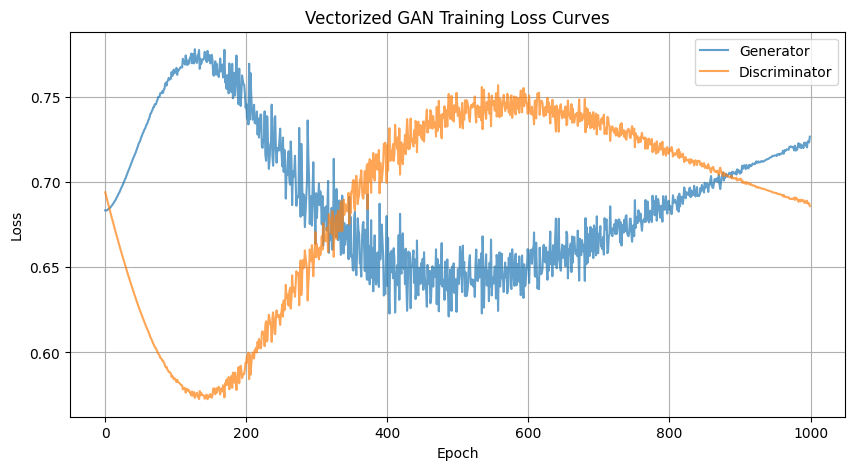

In [65]:
# Usage
np.random.seed(42)
D_vec = VectorizedDiscriminator()
G_vec = VectorizedGenerator()
trainer = VectorizedGANTrainer(D_vec, G_vec, lr=0.01, epochs=1000, batch_size=2)
trainer.train(random_faces)
trainer.plot_history()

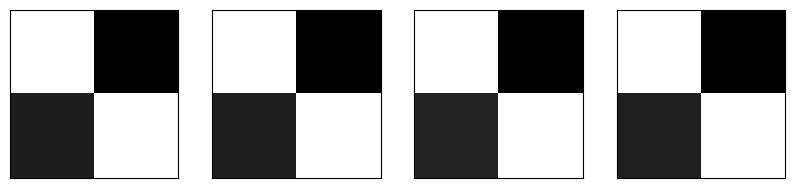

In [66]:
z = np.random.rand(1,4)
generated_images = G_vec.forward(z)
    
_ = view_samples(generated_images.T, 1, 4)

In [67]:
generated_images.T

array([[0.91858074, 0.05844724, 0.1438285 , 0.9148181 ],
       [0.91491758, 0.06149648, 0.14823578, 0.91108106],
       [0.8807888 , 0.09092731, 0.18660917, 0.87645017],
       [0.90846194, 0.0669254 , 0.15584861, 0.90450554]])

In [68]:
D_vec.forward(generated_images)

array([[0.47993783, 0.48036936, 0.48395917, 0.48110509]])